In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys

from thorr.utils import read_config, Logger, validate_start_end_dates
from thorr.database import Connect as db_connect


# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

# from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from joblib import dump, load

In [2]:
config_file = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')

config_dict = read_config(config_file)
project_dir = Path(config_dict["project"]["project_dir"])

insitu_data_dir = project_dir / "data/insitu/conditions/processed"

gpkg = "/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/data/GIS/hab.gpkg"

In [3]:
db = db_connect(config_file,)
schema = db.schema

connection = db.connection
cursor = connection.cursor()


In [4]:
# Retrieve the basin GIS data
basin_query = f"""
SELECT 
    "RegionID" as region_id,
    "Name",
    ST_AsBinary("geometry") AS geometry,
    ST_SRID("geometry") AS srid
FROM {schema}."Regions";
"""

cursor.execute(basin_query)
regions_gdf = gpd.GeoDataFrame(
    cursor.fetchall(),
    columns=[col[0] for col in cursor.description],
)

regions_gdf["geometry"] = gpd.GeoSeries.from_wkb(regions_gdf["geometry"])
regions_gdf = gpd.GeoDataFrame(regions_gdf, geometry="geometry")
regions_gdf = regions_gdf.set_crs(epsg=regions_gdf["srid"].iloc[0])

In [5]:
## Retrieve GIS data for reaches
query = f"""
SELECT
    "ReachID" AS reach_id,
    "Name" AS reach_name,
    "RiverID" AS river_id,
    "RKm",
    ST_AsBinary("buffered_geometry") AS geometry,
    ST_SRID("buffered_geometry") AS srid
FROM
    {schema}."Reaches"
ORDER By
    "ReachID";
"""

cursor.execute(query)
reaches_gdf = pd.DataFrame(
    cursor.fetchall(),
    columns=[col[0] for col in cursor.description],
)
reaches_gdf["geometry"] = gpd.GeoSeries.from_wkb(reaches_gdf["geometry"])
reaches_gdf = gpd.GeoDataFrame(reaches_gdf, geometry="geometry")
reaches_gdf = reaches_gdf.set_crs(epsg=reaches_gdf["srid"].iloc[0])

In [6]:

stations_metadata_path = Path(project_dir, "data/insitu/metadata/stations.csv")

stations_df = pd.read_csv(stations_metadata_path)
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.longitude, stations_df.latitude),
    crs="EPSG:4326"
)

# stations_fn = "stations_gis/stations.gpkg"
# stations = gpd.read_file(stations_fn, layer='Stations')
stations = stations_gdf.copy()

In [59]:
# # instead of the aquasat data, downloaded my own from WQP
# wqp_chl_samples_path = project_dir / "methods/01-data_collection/insitu/conditions/wqp/wqp_chl_samples_filtered.csv"
# wqp_chl_samples = pd.read_csv(wqp_chl_samples_path)
# wqp_chl_samples['ActivityStartDate_parsed'] = pd.to_datetime(wqp_chl_samples['ActivityStartDate'], errors='coerce')
# wqp_chl_samples['MonitoringLocationIdentifier'] = wqp_chl_samples['MonitoringLocationIdentifier'].astype(str)
# wqp_chl_samples.rename(columns={
#     "ActivityStartDate_parsed": "Date",
#     "chl_a_ug_L": "chl_a",
#     "MonitoringLocationIdentifier": "StationID"
# }, inplace=True)
# wqp_chl_samples.dropna(subset=['chl_a'], inplace=True)

filtered_wqp_path = project_dir / "methods/01-data_collection/insitu/conditions/wqp/wqp_data_filtered.csv"
filtered_wqp_df = pd.read_csv(filtered_wqp_path, low_memory=False)
chl_samples = filtered_wqp_df[
    (
        filtered_wqp_df["ResultMeasure/MeasureUnitCode"].isin(
            [
                "ug/L",
                "mg/L",
                "mg/m3"
                # 'ppb',
                # 'ug/g',
                # 'ug/kg',
                "ug/l",
            ]
        )
    ) & 
    # (filtered_wqp_df['CharacteristicName'].str.contains('Chlorophyll')) &
    (filtered_wqp_df['CharacteristicName'] == 'Chlorophyll a')
].copy()



In [60]:
chl_samples['CharacteristicName'].unique()

array(['Chlorophyll a'], dtype=object)

In [61]:
chl_samples['ResultMeasureValue'] = pd.to_numeric(chl_samples['ResultMeasureValue'], errors='coerce')
chl_samples['CharacteristicName'] = chl_samples['CharacteristicName'].astype('str')
chl_samples.dropna(subset=['ResultMeasureValue'], inplace=True)
chl_samples['ActivityStartDate_parsed'] = pd.to_datetime(chl_samples['ActivityStartDate'], errors='coerce')

In [62]:
for i, sample in chl_samples.iterrows():
    # print(sample[1]["ResultMeasureValue"], sample[1]["ResultMeasure.MeasureUnitCode"])
    match sample["ResultMeasure/MeasureUnitCode"]:
        case "ug/L" | "ug/l" | "ug/l      " | "mg/m3" | "ppb       " | "ppb":
            chl_samples.at[i, 'chl_a_ug_L'] = sample["ResultMeasureValue"]
        case "mg/L" | "mg/l" | "ug/ml" | "ppm":
            chl_samples.at[i, 'chl_a_ug_L'] = sample["ResultMeasureValue"] * 1000

# filter chlorophyll concentrations to reasonable values
chl_samples = chl_samples[(chl_samples['chl_a_ug_L'] > .01) & (chl_samples['chl_a_ug_L'] < 10000)].copy()


chl_samples.rename(columns={
    "ActivityStartDate_parsed": "Date",
    "chl_a_ug_L": "chl_a",
    "MonitoringLocationIdentifier": "StationID"}, inplace=True)


In [63]:
chl_samples.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'ActivityTypeCode', 'ActivityMediaName',
       'ActivityMediaSubdivisionName', 'ActivityStartDate',
       'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode',
       'ActivityEndDate', 'ActivityEndTime/Time',
       'ActivityEndTime/TimeZoneCode',
       'ActivityDepthHeightMeasure/MeasureValue',
       'ActivityDepthHeightMeasure/MeasureUnitCode',
       'ActivityDepthAltitudeReferencePointText',
       'ActivityTopDepthHeightMeasure/MeasureValue',
       'ActivityTopDepthHeightMeasure/MeasureUnitCode',
       'ActivityBottomDepthHeightMeasure/MeasureValue',
       'ActivityBottomDepthHeightMeasure/MeasureUnitCode', 'ProjectIdentifier',
       'ActivityConductingOrganizationText', 'StationID',
       'ActivityCommentText', 'SampleAquifer', 'HydrologicCondition',
       'HydrologicEvent', 'SampleCollectionMethod/MethodIdentifier',
       'SampleCollectionMethod/MethodIdentifierContext',
   

In [64]:
chl_locations = stations_gdf[stations_gdf['available_data'].apply(lambda x: 'conditions' in json.loads(x))]
chl_locations = chl_locations[chl_locations['available_data'].apply(lambda x: ("avg_f_chla (ug/L)" in json.loads(x)['conditions']) or ("min_avg_f_chla (ug/L)" in json.loads(x)['conditions']) or ("max_avg_f_chla (ug/L)" in json.loads(x)['conditions']))]

In [65]:
conus_regions_gdf = regions_gdf[regions_gdf["Name"] != 'Alaska Region'].copy()

In [66]:
chl_locations_in_buffer = gpd.read_file(gpkg, layer='chl_stations_in_buffer')
chl_locations_in_buffer.rename(columns={'station_ID': 'StationID'}, inplace=True)
wqp_sites = gpd.read_file(project_dir / 'methods/01-data_collection/insitu/conditions/wqp/wqp_sites.gpkg', layer='wqp_chl_sites_filtered')
wqp_sites['StationID'] = wqp_sites['MonitoringLocationIdentifier'].astype(str)

In [67]:
wqp_sites.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'MonitoringLocationIdentifier', 'MonitoringLocationName',
       'MonitoringLocationTypeName', 'MonitoringLocationDescriptionText',
       'HUCEightDigitCode', 'DrainageAreaMeasure/MeasureValue',
       'DrainageAreaMeasure/MeasureUnitCode',
       'ContributingDrainageAreaMeasure/MeasureValue',
       'ContributingDrainageAreaMeasure/MeasureUnitCode', 'LatitudeMeasure',
       'LongitudeMeasure', 'SourceMapScaleNumeric',
       'HorizontalAccuracyMeasure/MeasureValue',
       'HorizontalAccuracyMeasure/MeasureUnitCode',
       'HorizontalCollectionMethodName',
       'HorizontalCoordinateReferenceSystemDatumName',
       'VerticalMeasure/MeasureValue', 'VerticalMeasure/MeasureUnitCode',
       'VerticalAccuracyMeasure/MeasureValue',
       'VerticalAccuracyMeasure/MeasureUnitCode',
       'VerticalCollectionMethodName',
       'VerticalCoordinateReferenceSystemDatumName', 'CountryCode',
       'StateCode', 'CountyCode',

In [68]:
print(f"Number of USGS chl locations in buffer: {len(chl_locations_in_buffer)}")
# print(f"Number of unique chl locations in buffer: {len(wqp_aquasat_gdf_in_buffer['StationID'].unique())}")
print(f"Number of unique WQP chl locations in buffer: {len(wqp_sites)}")

Number of USGS chl locations in buffer: 12
Number of unique WQP chl locations in buffer: 3773


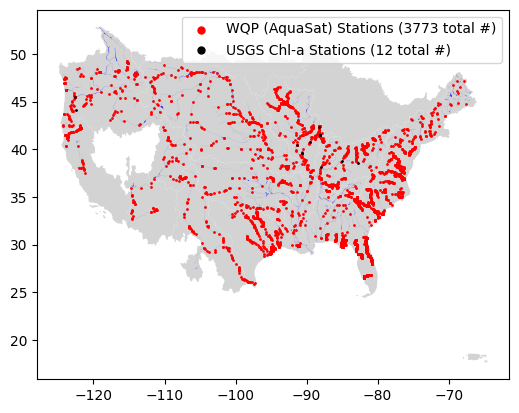

In [69]:
fig, ax = plt.subplots()
conus_regions_gdf.plot(ax=ax,color='lightgray')
reaches_gdf.plot(ax=ax, color='blue')
wqp_sites.plot(ax=ax, color='r', markersize=1, label=f'WQP (AquaSat) Stations ({len(wqp_sites)} total #)')
chl_locations_in_buffer.plot(ax=ax, color='k', markersize=1, label=f'USGS Chl-a Stations ({len(chl_locations_in_buffer)} total #)')
ax.legend(markerscale=5);

In [70]:
stations_in_buffer = pd.concat([chl_locations_in_buffer[['StationID', 'geometry']], wqp_sites[['StationID', 'geometry']]]).drop_duplicates().reset_index(drop=True)
stations_in_buffer = stations_in_buffer.sjoin(reaches_gdf[['reach_id', 'geometry']], how='left', predicate='within')
stations_in_buffer.drop(columns=['index_right'], inplace=True)

In [71]:
# chl_locations_in_buffer
chl_insitu = pd.DataFrame()

for station_loc in stations_in_buffer.itertuples():
    insitu_fn = insitu_data_dir / f"{station_loc.StationID}.csv"
    # print(f"Processing station: {station_loc.StationID}")

    if insitu_fn.exists():
        insitu_data = pd.read_csv(insitu_fn, parse_dates=['date'])
        # print(insitu_data.columns)
        # drop utc in date
        insitu_data['date'] = insitu_data['date'].dt.tz_localize(None)

        # keep date and average temperature
        # insitu_data = insitu_data[['date', 'avg_temp(C)', ]]
        # replace -999999 with nan
        # insitu_data.replace(-999999, np.nan, inplace=True)
        insitu_data.dropna(subset=['avg_f_chla (ug/L)'], inplace=True)
        insitu_data['StationID'] = station_loc.StationID
        # insitu_data['RKm'] = chl_loc.RKm
        # insitu_data['Name'] = chl_loc.reach_id
        chl_insitu = pd.concat([chl_insitu, insitu_data])
        # break

# chl_insitu = pd.concat(chl_insitu)

chl_insitu.rename(columns={'station_ID': 'StationID', 'date': 'Date', 'avg_f_chla (ug/L)': 'chl_a'}, inplace=True)
chl_insitu.dropna(subset=['chl_a'], inplace=True)
# combined_insitu = combined_insitu.merge(lsat_data, on='Date', how='left')
# Data/insitu/conditions/processed

In [72]:
chl_samples.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityTypeCode,ActivityMediaName,ActivityMediaSubdivisionName,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,ActivityEndDate,...,LaboratoryName,AnalysisStartDate,ResultLaboratoryCommentText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode,PreparationStartDate,ProviderName,Date,chl_a
20103,1VTDECWQ,Vermont Dept of Environmental Conservation,1VTDECWQ-SWQID-0001871654,Field Msr/Obs,Water,NaN,2018-05-03,10:30:00,EST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET,2018-05-03,1.40
20104,1VTDECWQ,Vermont Dept of Environmental Conservation,1VTDECWQ-SWQID-0001871639,Field Msr/Obs,Water,NaN,2018-05-03,10:21:00,EST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET,2018-05-03,1.50
20108,1VTDECWQ,Vermont Dept of Environmental Conservation,1VTDECWQ-SWQID-0001871656,Field Msr/Obs,Water,NaN,2018-05-03,10:31:00,EST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET,2018-05-03,1.43
20110,1VTDECWQ,Vermont Dept of Environmental Conservation,1VTDECWQ-SWQID-0001871638,Field Msr/Obs,Water,NaN,2018-05-03,10:21:00,EST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET,2018-05-03,1.48
20111,1VTDECWQ,Vermont Dept of Environmental Conservation,1VTDECWQ-SWQID-0001871650,Field Msr/Obs,Water,NaN,2018-05-03,10:28:00,EST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET,2018-05-03,1.41


In [74]:
chl_samples.drop_duplicates(subset=["Date", "chl_a", "StationID"], inplace=True)

In [75]:

# chl_wqp_usgs = pd.concat([chl_insitu[['StationID', 'Date', 'chl_a']], wqp_chl_samples[['StationID', 'Date', 'chl_a']]], ignore_index=True)
chl_wqp_usgs = pd.concat([chl_insitu[['StationID', 'Date', 'chl_a']], chl_samples[['StationID', 'Date', 'chl_a']]], ignore_index=True)
chl_wqp_usgs = chl_wqp_usgs[(chl_wqp_usgs['chl_a'] > 0) & (chl_wqp_usgs['chl_a'].notna())].copy()

In [76]:
chl_wqp_usgs = chl_wqp_usgs.merge(stations_in_buffer[['StationID', 'reach_id']], on='StationID', how='inner')
chl_wqp_usgs.rename(columns={'reach_id': 'ReachID'}, inplace=True)

In [77]:
chl_wqp_usgs.to_csv('chl_wqp_usgs.csv', index=False)

In [78]:
# HLS L30 and S30 station data queries
reach_hlsl30_query = f"""
SELECT *
FROM {db.schema}."ReachHLSL30"
"""

reach_hlss30_query = f"""
SELECT *
FROM {db.schema}."ReachHLSS30"
"""

# fetch the data into a dataframe as df
with connection.cursor() as cursor:
    cursor.execute(reach_hlsl30_query)
    reach_hlsl30 = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
    reach_hlsl30["Date"] = pd.to_datetime(reach_hlsl30["Date"])

with connection.cursor() as cursor:
    cursor.execute(reach_hlss30_query)
    reach_hlss30 = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
    reach_hlss30["Date"] = pd.to_datetime(reach_hlss30["Date"])

reach_hlsl30["mission"] = "l30"
reach_hlss30["mission"] = "s30"
# hls_merge = pd.merge(
#     reach_hlsl30,
#     reach_hlss30,
#     on=["ReachID", "Date"],
#     suffixes=("_l30", "_s30"),
#     how="outer"
# )
# print(f"No. of records in merged HLS L30 and S30 data: {len(hls_merge)}")

hls_df = pd.concat([reach_hlsl30, reach_hlss30], ignore_index=True)

In [79]:
hls_insitu = pd.merge(
    hls_df,
    chl_wqp_usgs,
    on=["ReachID", "Date"],
    how="outer",
    # how="inner"
)

# calculate mbr using spatially averaged band values instead of the pixel values
hls_insitu['mbr_v2'] = hls_insitu[["b01_median", "b02_median"]].max(axis=1) / hls_insitu["b03_median"]

hls_insitu.to_csv(project_dir / "data/hls_insitu/hls_insitu_new.csv", index=False)